In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'tomatoleaf:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F619181%2F1105687%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240723%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240723T073830Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D6c380219f6aae7ec9b5a7d6086e325cafdf4894e1c4e19ab0aadcdfe3077b433519647aede72da166558b0567d38e0f1cc46d41c40e05ea348103673df14a39ba58781654c2ebdccbb73080c2acc4d7322d4029f8813a488f6ec699a110c5f0cb9279d247e710ce24f35623fa37df935d2928cc4df56e8bb8c41b8ea0ee1978ec4b9e122c8a2645b66166a298855217d15764eac72f32b070a7bfadbbdae11507064988a8506913edd373d50e2559dc586d569a17a617a27e3654ed08689c8dafd2a678de2ce74741d39c97d3432633e71b745a124d77705357807efa2883af9b69ad2f04ac1dd56312a9d404891898cb01469e4d281a9b920423d1c6d2179e1'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 187559775 bytes downloaded
Downloaded and uncompressed: tomatoleaf
Data source import complete.


## Import Libraries

In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers,callbacks
import matplotlib.pyplot as plt
import keras
import seaborn as sns
from keras.applications import EfficientNetB3
import numpy as np
from sklearn.metrics import confusion_matrix
import zipfile
import os


In [3]:
!pip show tensorflow


Name: tensorflow
Version: 2.15.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, setuptools, six, tensorboard, tensorflow-estimator, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine_rl, tf_keras


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
%cd drive/MyDrive/Lung_Classification/

/content/drive/MyDrive/Lung_Classification


## Set Constants

In [6]:
IMG_SIZE=130
BATCH_SIZE=32
CHANNELS=3
EPOCHS=20
INPUT_SHAPE = (BATCH_SIZE, IMG_SIZE, IMG_SIZE, CHANNELS)
N_CLASSES = 10

## Import data into tensorflow dataset object

In [7]:
training= tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/tomatoleaf/tomato/train",
    seed=123,
    shuffle=True,
    image_size=(IMG_SIZE,IMG_SIZE),
    batch_size=BATCH_SIZE,

)
validation= tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/tomatoleaf/tomato/val",
    seed=123,
    shuffle=False,
    image_size=(IMG_SIZE,IMG_SIZE),
    batch_size=BATCH_SIZE
)

Found 10000 files belonging to 10 classes.
Found 1000 files belonging to 10 classes.


In [8]:
classes_name=training.class_names
classes_name

['Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

In [ ]:
for batch_img,batch_label in training.take(1):
    print(batch_img.shape)
    print(batch_label.numpy())

## Show some samples of images!

In [ ]:
plt.figure(figsize=(20, 20))
plt.suptitle('Samples of Tomato Plant!')
for batch_img,batch_label in training.take(1):
   for i in range(20):
      ax=plt.subplot(5,4,i+1)
      plt.title(classes_name[batch_label[i]])
      plt.imshow(batch_img[i].numpy().astype('uint8'))
      plt.axis('off')

In [9]:
def split_train_val_test(dataset,train_split=0.8,test_split=0.1,val_split=0.1,shuffle=True,shuffle_size=10000):
   assert(train_split+val_split+test_split)==1


   if shuffle:
        dataset = dataset.shuffle(shuffle_size, seed=12)
    #set size of train,test and val
   train_size=int(train_split*len(dataset))
   val_size=int(val_split*len(dataset))
   test_size=int(test_split*len(dataset))


   train_ds=dataset.take(train_size)
   val_ds=dataset.skip(train_size).take(val_size)
   test_ds=dataset.skip(train_size+val_size).take(test_size)


   return train_ds,val_ds,test_ds



In [10]:
train,val,test=split_train_val_test(training)

In [11]:
print(len(train))
print(len(test))
print(len(val))

250
31
31


## Cache, Shuffle, and Prefetch the Dataset

In [12]:
train_ds = train.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Creating a Layer for Resizing and Normalization

In [13]:
resize_scaling=tf.keras.Sequential([
    layers.Resizing(IMG_SIZE,IMG_SIZE),
    layers.Rescaling(1./255)
])

## Build The Model

#### EfficientNetB3

In [24]:
base_model = EfficientNetB3(weights='imagenet',pooling='max',include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

In [25]:
model=tf.keras.models.Sequential([
    base_model,
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dense(N_CLASSES,activation='softmax')

])


In [26]:
model.build(input_shape=INPUT_SHAPE)

In [27]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional  (None, 1536)              10783535  
 )                                                               
                                                                 
 batch_normalization_1 (Bat  (None, 1536)              6144      
 chNormalization)                                                
                                                                 
 flatten_2 (Flatten)         (None, 1536)              0         
                                                                 
 dense_4 (Dense)             (None, 128)               196736    
                                                                 
 dense_5 (Dense)             (None, 10)                1290      
                                                                 
Total params: 10987705 (41.91 MB)
Trainable params: 10

In [28]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [29]:
erl=callbacks.EarlyStopping(monitor='val_loss',patience=5,mode='min')
save_ck=callbacks.ModelCheckpoint('.tomato_wt.hdf5',monitor='val_loss',save_best_only=True,mode='min')

In [30]:
history=model.fit(train_ds,validation_data=val_ds,epochs=EPOCHS,batch_size=BATCH_SIZE,verbose=1,
               callbacks=[save_ck])

Epoch 1/20
250/250 [==============================] - 121s 247ms/step - loss: 0.6226 - accuracy: 0.8170 - val_loss: 0.6733 - val_accuracy: 0.9073
Epoch 2/20
250/250 [==============================] - 54s 216ms/step - loss: 0.3053 - accuracy: 0.9243 - val_loss: 26.1938 - val_accuracy: 0.4435
Epoch 3/20
250/250 [==============================] - 62s 248ms/step - loss: 0.3016 - accuracy: 0.9190 - val_loss: 0.5286 - val_accuracy: 0.9435
Epoch 4/20
250/250 [==============================] - 60s 240ms/step - loss: 0.0936 - accuracy: 0.9714 - val_loss: 0.0544 - val_accuracy: 0.9778
Epoch 5/20
250/250 [==============================] - 54s 217ms/step - loss: 0.0546 - accuracy: 0.9836 - val_loss: 0.1918 - val_accuracy: 0.9536
Epoch 6/20
250/250 [==============================] - 54s 216ms/step - loss: 0.1399 - accuracy: 0.9604 - val_loss: 0.3242 - val_accuracy: 0.9234
Epoch 7/20
250/250 [==============================] - 55s 221ms/step - loss: 0.1186 - accuracy: 0.9688 - val_loss: 0.3467 - val_

## Show The Model performance!

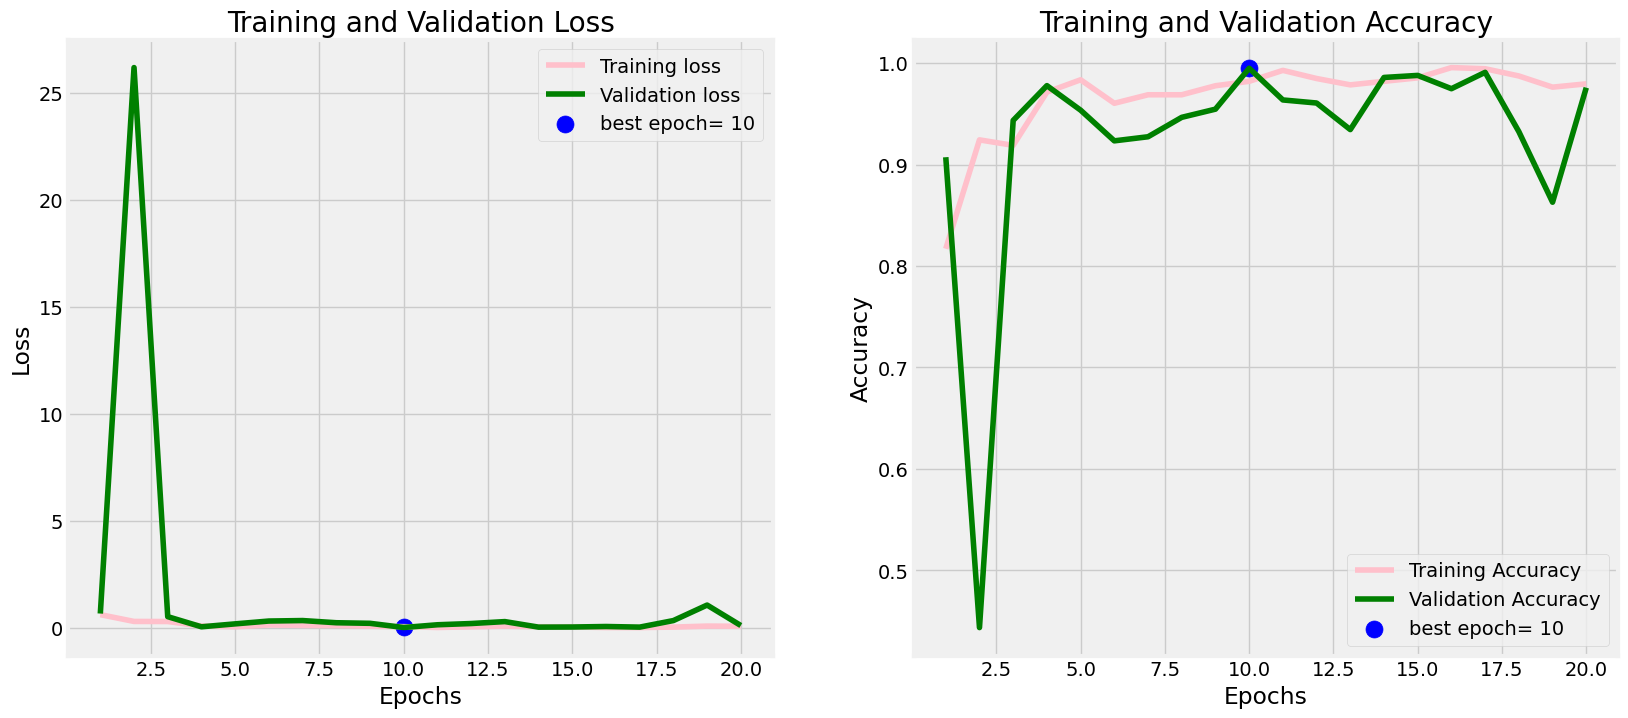

In [31]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'pink', label= 'Training loss')
plt.plot(Epochs, val_loss, 'green', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'pink', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'green', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

## Evaluate The Model

In [32]:
train_score = model.evaluate(train_ds, verbose= 1)
valid_score = model.evaluate(val_ds, verbose= 1)
test_score = model.evaluate(test_ds, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])


31/31 [==============================] - 9s 53ms/step - loss: 0.1449 - accuracy: 0.9738
Train Loss:  0.11706149578094482
Train Accuracy:  0.9788326621055603
--------------------
Validation Loss:  0.11490467935800552
Validation Accuracy:  0.975806474685669
--------------------
Test Loss:  0.1449301689863205
Test Accuracy:  0.9737903475761414


## Get The Predictions!

In [ ]:
def get_predicitions():
    all_true_labels = []
    all_predicted_labels = []
    all_images=[]
    classes_name=training.class_names

    #get all the predictions and true labels
    for image_batch, label_batch in test_ds:
            # Make predictions on the batch
            predictions = model.predict(image_batch)

            # Convert predictions to class indices
            predicted_labels = np.argmax(predictions, axis=1)

            #append matrix of images
            all_images.extend(image_batch)

            # Convert true labels to numpy array
            true_labels = label_batch

            all_true_labels.extend(true_labels)
            all_predicted_labels.extend(predicted_labels)



    #plot the predictions
    index=0
    plt.figure(figsize=(25, 25))
    plt.suptitle('Prediction of Tomato Disease!')

    for i in range(30,61):
        if index<15:
            ax=plt.subplot(5,3,index+1)
            color = 'green' if all_true_labels[i] == all_predicted_labels[i] else 'red'
            plt.title(f'true_class:{classes_name[all_true_labels[i]]}\npredicted_class{classes_name[all_predicted_labels[i]]}',color=color)
            plt.imshow(np.array(all_images[i]).astype('uint8'))
            plt.axis('off')
            index+=1
        else:
            index=0


In [ ]:
get_predicitions()

## Show Confusion Matrix!


In [ ]:
def display_conf_matrix():
    all_true_labels=[]
    all_predicted_labels=[]
    for image_batch, label_batch in test_ds:
        # Make predictions on the batch
        predictions = model.predict(image_batch)

        # Convert predictions to class indices
        predicted_labels = np.argmax(predictions, axis=1)

        # Convert true labels to numpy array
        true_labels = label_batch.numpy()

        all_true_labels.extend(true_labels)
        all_predicted_labels.extend(predicted_labels)

    # Convert lists to numpy arrays
    all_true_labels = np.array(all_true_labels)
    all_predicted_labels = np.array(all_predicted_labels)
    conf_matrix = confusion_matrix(all_true_labels, all_predicted_labels)

        # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=training.class_names, yticklabels=training.class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

In [ ]:
display_conf_matrix()

In [ ]:
model_save_path = '/kaggle/working/classifier.h5'
model.(model_save_path)

In [ ]:
import shutil

model.export('saved_model')
# Specify the folder you want to compress
folder_path = '/kaggle/working/saved_model/tomato_model'

# Specify the name of the output ZIP file
zip_file_path = '/kaggle/working/tomato_model.zip'

# Compress the folder into a ZIP file
shutil.make_archive(base_name='/kaggle/working/tomato_model', format='zip', root_dir=folder_path)


NameError: name 'model' is not defined